# Import liabraries

In [1]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 8.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import skimage
from skimage import io

# Data Cleaning and Preprocessing

In [3]:
def clean_dataframe(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Drop the "Unnamed: 0" column
    df = df.drop("Unnamed: 0", axis=1)

    # Check for missing values
    print(df.isna().sum())

    # Drop missing values
    df = df.dropna()

    # Drop duplicate rows
    df = df.drop_duplicates()

    # Keep only the first occurrence of each track name
    df.drop_duplicates(subset=['track_name'], keep='first', inplace=True)

    # Convert the 'explicit' column to int type
    df['explicit'] = df['explicit'].astype(int)

    return df

In [4]:
df = clean_dataframe("BugKiller_Project/dataset.csv")

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


# Recommendation System

## Feature Generation
One-hot Encoding  
Normalization

In [61]:
def one_hot_encoding(df, column, new_name): 
    ''' 
    Create One Hot Encoded features of a specific column
    ---
    Input: 
    df (pandas dataframe): Spotify Dataframe
    column (str): Column to be processed
    new_name (str): new column name to be used
        
    Output: 
    tf_df: One-hot encoded features 
    '''
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [62]:
def create_feature_set(df):
    '''
    Process spotify df to create a final set of features that will be used to generate recommendations
    ---
    Input: 
    df (pandas dataframe): Spotify Dataframe
            
    Output: 
    final (pandas dataframe): Final set of features 
    '''

    # One-hot Encoding
    genre_ohe = one_hot_encoding(df, 'track_genre', 'genre_encode')

    # Normalization
    feature_cols = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 
                'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                'liveness', 'valence', 'tempo', 'time_signature']
    scaler = MinMaxScaler()
    normalized_df =scaler.fit_transform(df[feature_cols])
    normalized_df = pd.DataFrame(normalized_df, columns=feature_cols)

    # Concatenate all features
    final = pd.concat([normalized_df, genre_ohe], axis=1)
    
    return final

## content_based recommendation system
cosine similarity

In [63]:
def cosine_model(df):
    complete_feature_set = create_feature_set(df)
    return cosine_similarity(complete_feature_set)

In [64]:
indices = pd.Series(df.index, index=df['track_name']).drop_duplicates()

def generate_recommendation(track_name, model_type):
    index=indices[track_name]
    score=list(enumerate(model_type[index]))
    similarity_score = sorted(score,key = lambda x:x[1],reverse = True)
    similarity_score = similarity_score[1:11]
    top_songs_index = [i[0] for i in similarity_score]
    top_songs=sample_df['track_name'].iloc[top_songs_index]
    return top_songs

## spotify api

In [65]:
# Here need to use the spotify api to save the client id and client secret as a text file.
# In the example, you can skip this part, because we save the data needed in this example locally.
"""
with open('/content/spotify_api.txt', 'r') as file:
    client_id = file.readline().strip()
    client_secret = file.readline().strip()

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
"""

"\nwith open('/content/spotify_api.txt', 'r') as file:\n    client_id = file.readline().strip()\n    client_secret = file.readline().strip()\n\nclient_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)\nsp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)\n"

## output df

In [66]:
def create_feature_set(recommend_playlist_name):
    playlist = pd.DataFrame()
    for name in recommend_playlist_name:
        results = sp.search(q=name, type='track', limit=1)
        if results['tracks']['total'] > 0:
            for ix, i in enumerate(results['tracks']['items']):
                playlist = playlist.append({
                    'artist': i['artists'][0]['name'],
                    'name': i['name'],
                    'id': i['id'],
                    'url': i['album']['images'][1]['url']
                }, ignore_index=True)
        else:
            print('No results found for track:', name)
    return playlist

In [67]:
import os

def create_outputs(recommend_playlist_name):
    playlist = pd.DataFrame()
    for name in recommend_playlist_name:
        results = sp.search(q=name, type='track', limit=1)
        if results['tracks']['total'] > 0:
            for ix, i in enumerate(results['tracks']['items']):
                playlist = playlist.append({
                    'artist': i['artists'][0]['name'],
                    'name': i['name'],
                    'id': i['id'],
                    'url': i['album']['images'][1]['url']
                }, ignore_index=True)
        else:
            print('No results found for track:', name)

    # Save the DataFrame to a CSV file
    if not os.path.exists('output'):
        os.makedirs('output')
    playlist.to_csv('output/playlist.csv', index=False)
    
    return playlist

## visulization

In [68]:
import os

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns) + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    # Save the figure locally
    # if not os.path.exists('output'):
    #     os.makedirs('output')
    # plt.savefig('output/visualize_songs.png')
    
    plt.show()

## Example of recommendation system
Because you can't visualize the results without signing up for the spotify API. So here is an example of visualizing the results using 10,000 sample data (the original data set is larger and the training speed is slower). We store the results locally, so we can use visualize_songs() function.

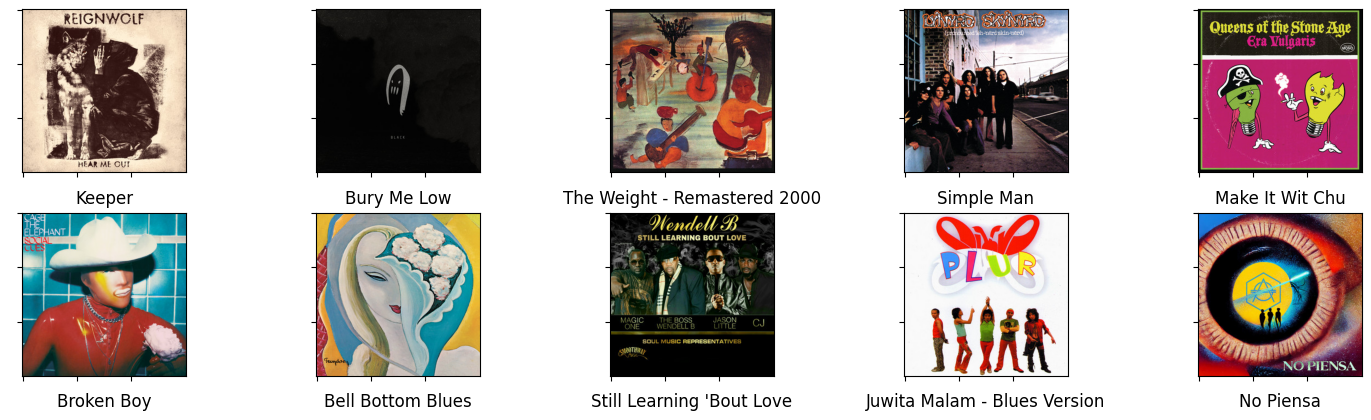

In [69]:
df_recommended_songs = pd.read_csv("BugKiller_Project/playlist.csv")
visualize_songs(df_recommended_songs)